In [1]:
# import libraries
import os
import sys
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [2]:
# check the environment
print("Current working directory: ", os.getcwd())
print("OS name: ", sys.platform)
print("Python executable: ", sys.executable)
print("Python version: ", sys.version)
print("PyTorch version: ", torch.__version__)
print("PyTorch Lightning version: ", pl.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())
print("Number of GPUs: ", torch.cuda.device_count())
print("GPU model: ", torch.cuda.get_device_name(0))

Current working directory:  /gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D
OS name:  linux
Python executable:  /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/bin/python
Python version:  3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
PyTorch version:  2.0.1+cu117
PyTorch Lightning version:  1.9.3
CUDA version:  11.7
cuDNN version:  8500
Number of GPUs:  1
GPU model:  Tesla V100-PCIE-32GB


In [3]:
# import modules
sys.path.append('../')
from SR3D.scripts.data import get_data, get_norm_dataset, get_dataloader
from SR3D.scripts.unet_modules import Upsample
from SR3D.scripts.diffusion import Diffusion
from SR3D.scripts.scheduler import linear_beta_schedule, TimestepSampler
from SR3D.scripts.unet import Unet
from SR3D.scripts.main import Unet_pl, setup_trainer

In [4]:
print("Hello World!")
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


Hello World!


1234

In [5]:
### training params
num_epochs = 300
batch_size =1
learning_rate = 1e-5
learning_rate_decay = 0.99

### diffusion params
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02

### data params
LR_dir = "/gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid32_CIC_noRSD/"
HR_dir = "/gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid128_CIC_noRSD/"
mid_dir = "/gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid64_CIC_noRSD/"

n_maps=100
rate_train =0.8

### model parameters
save_dir = '/gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/ckpt_logs'

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
### data
data_hr = get_data(mid_dir, n_maps=n_maps)
data_lr = get_data(LR_dir, n_maps=n_maps)
combined_dataset, transforms, inverse_transforms, RANGE_MIN, RANGE_MAX = get_norm_dataset(data_hr, data_lr)
train_loader, val_loader = get_dataloader(combined_dataset, rate_train, batch_size)

In [8]:
sampler = TimestepSampler(sampler_type='uniform', timesteps=timesteps, device=device)

Sampler type uniform


In [9]:
model = Unet_pl(
        channels = 1,
        dim = 64,
        init_dim = 64,
        out_dim = 1,
        batch_size = batch_size,
        learning_rate = learning_rate,
        learning_rate_decay = learning_rate_decay,
        num_epochs = num_epochs,
        timesteps = timesteps,
        beta_start = beta_start,
        beta_end = beta_end,
        loss_type="huber", 
        sampler=sampler, 
        conditional=True).to(device)

# Generate map

In [58]:
ckpt_log = save_dir + "/SR3D_diffusion/version_4/checkpoints/last.ckpt"
sd = torch.load(ckpt_log)["state_dict"]
model.load_state_dict(sd)
model.eval()
model.freeze()

In [59]:
tmp_diffusion = model.diffusion

In [60]:
import matplotlib.pyplot as plt
import numpy as np

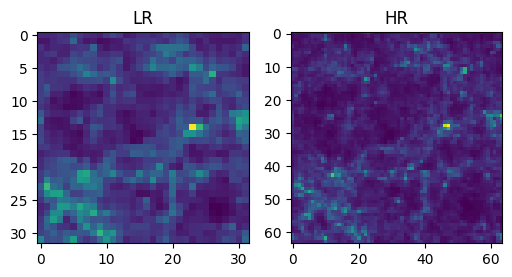

In [61]:
# project the data to 2D
lr_proj = combined_dataset.tensors[1][0].cpu().numpy()
lr_proj = lr_proj.squeeze(0)
lr_proj = np.sum(lr_proj, axis=0)

hr_proj = combined_dataset.tensors[0][0].cpu().numpy()
hr_proj = hr_proj.squeeze(0)
hr_proj = np.sum(hr_proj, axis=0)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(lr_proj)
ax[0].set_title("LR")
ax[1].imshow(hr_proj)
ax[1].set_title("HR")
plt.show()

In [62]:
map_dir = save_dir + "/../generated"
if not os.path.exists(map_dir):
        os.makedirs(map_dir)

In [63]:
print("Start Diffusion")
tmp_hr = combined_dataset.tensors[0][0].unsqueeze(0).to(device)
tmp_lr = combined_dataset.tensors[1][0].unsqueeze(0).to(device)
tmp_upsample_lr = nn.Upsample(scale_factor = 2, mode='trilinear')(tmp_lr)
tmp_sample = tmp_hr - tmp_upsample_lr
q_sample = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), timesteps-1, device=device))
img = torch.randn(tmp_sample.shape, device=device)

Start Diffusion


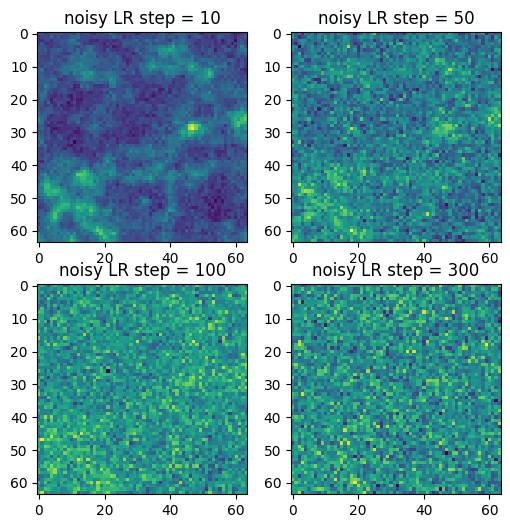

In [67]:
# plot diffused maps
fig, ax = plt.subplots(2,2, figsize=(6,6))
tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 10-1, device=device))+tmp_upsample_lr 
ax[0,0].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,0].set_title("noisy LR step = 10")

tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 50-1, device=device))+tmp_upsample_lr
ax[0,1].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,1].set_title("noisy LR step = 50")

tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 100-1, device=device))+tmp_upsample_lr
ax[1,0].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,0].set_title("noisy LR step = 100")

tmp = tmp_diffusion.q_sample(tmp_sample, torch.full((1,), 300-1, device=device))+tmp_upsample_lr
ax[1,1].imshow((tmp+tmp_upsample_lr).squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,1].set_title("noisy LR step = 300")
plt.show()

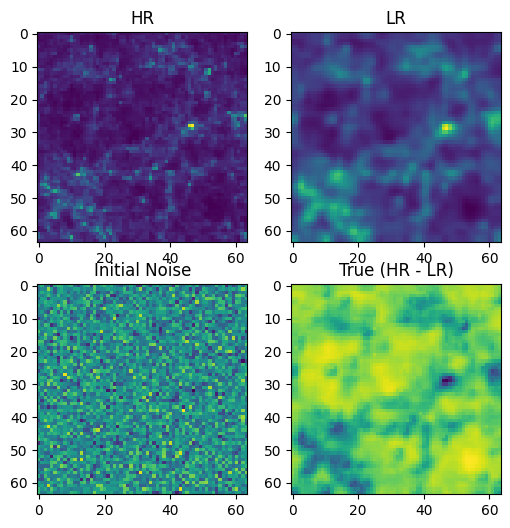

In [65]:
# plot initial image
fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].imshow(tmp_hr.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,0].set_title("HR")
ax[0,1].imshow(tmp_upsample_lr.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[0,1].set_title("LR")
ax[1,0].imshow(img.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,0].set_title("Initial Noise")
ax[1,1].imshow(tmp_sample.squeeze(0).squeeze(0).cpu().numpy().sum(axis=0))
ax[1,1].set_title("True (HR - LR)")
plt.show()

In [73]:
print(img.min().detach().cpu().numpy(), img.max().detach().cpu().numpy())
print(tmp_sample.min().detach().cpu().numpy(), tmp_sample.max().detach().cpu().numpy())

-4.7344923 4.305432
-0.6837623 0.23722827


In [48]:
from tqdm import tqdm

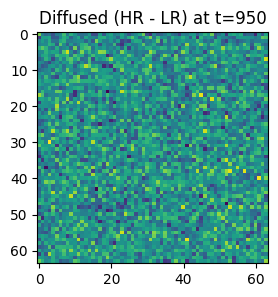

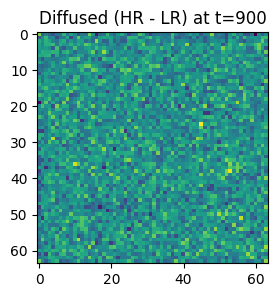

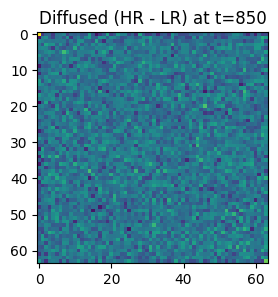

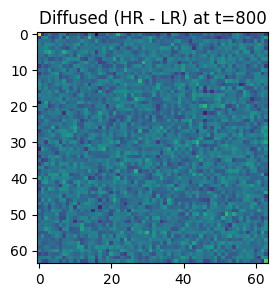

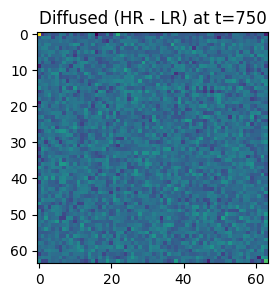

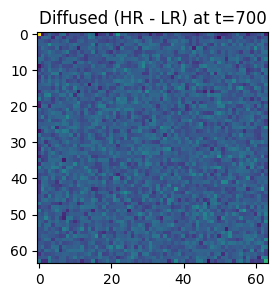

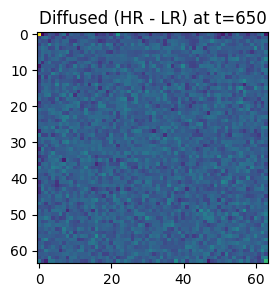

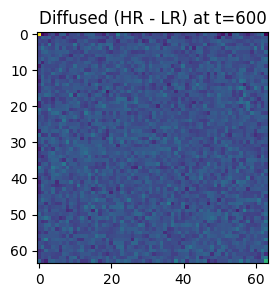

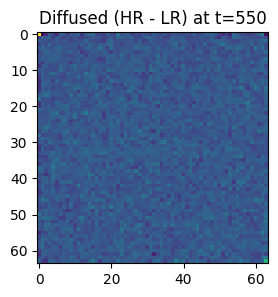

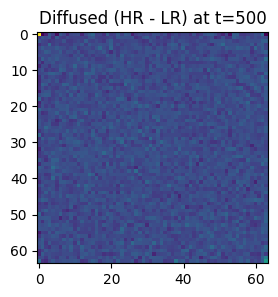

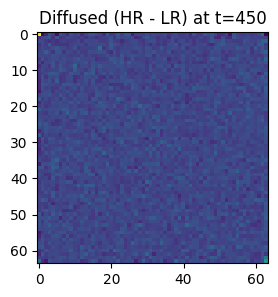

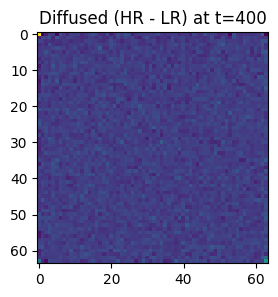

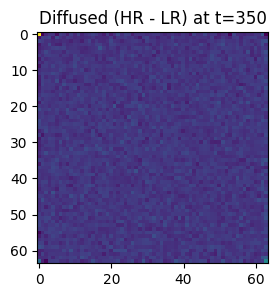

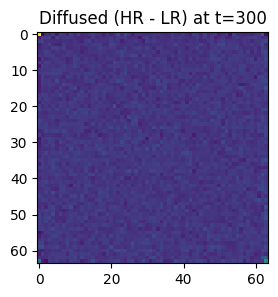

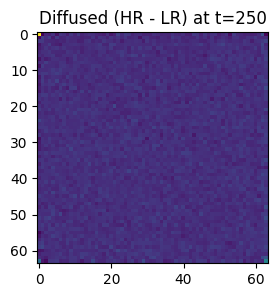

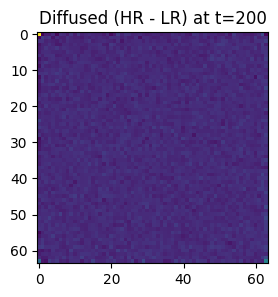

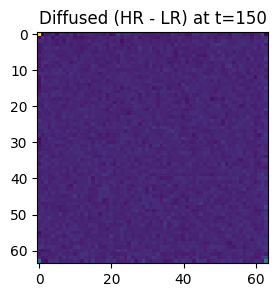

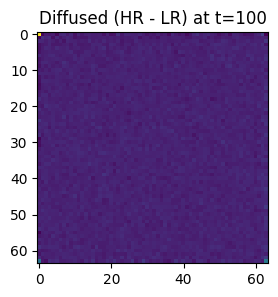

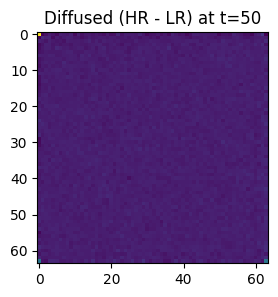

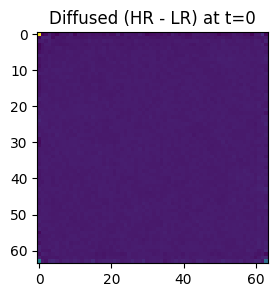

In [80]:
model.eval()
model.freeze()
imgs = []
for j in reversed(range(0, timesteps)):
    t = torch.full((1,), j, device=device, dtype=torch.long)
    loss = tmp_diffusion.p_losses(model.model, tmp_sample, t, labels=tmp_upsample_lr)
    img = tmp_diffusion.p_sample(model.model, img, t, j, label=tmp_upsample_lr)
    #print('Step {}, Loss {}'.format(j, loss), flush=True)
    if (j % 50 == 0):
        diffmap = img.detach().cpu().numpy().squeeze(0).squeeze(0).sum(axis=0)
        imgs.append(diffmap)
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        ax.imshow(diffmap)
        ax.set_title("Diffused (HR - LR) at t={}".format(j))
        plt.show()
        plt.close()